# <a name="P3">Bayesian Neural Network
## A) Implement neural network in Julia
Ref: 
- https://colab.research.google.com/github/papercup-open-source/tutorials/blob/master/intro_bnn/Bayesian_neural_networks_Part_2.ipynb#scrollTo=6aJWCyzZxFa3
- https://turing.ml/dev/tutorials/3-bayesnn/
- https://fluxml.ai/Flux.jl/stable/models/basics/

In [ ]:
# Set up
x_range = -10:0.1:10
D=[-3 -3.5; 2 6; 3 4; -3.5 -3; 4 4.5]
x=D[:,1]
t=D[:,2]
# The key for random function is omitted

5-element Array{Float64,1}:
 -3.5
  6.0
  4.0
 -3.0
  4.5

In [ ]:
function forward_step(W, x)
    W1 = reshape(W[1:25],1,25)
    W1b = reshape(W[26:50],1,25)
    W2 = reshape(W[51:76],26,1)

    a1 = x .* W1 .+ W1b #a1 = np.dot(x, W1) + W1b -> 5*25 matrix, add W1b to each row of x.*W1
    a1 = a1 .+ W1b
    y1 = tanh.(a1) #y1 = np.tanh(a1) -> 5*25
    y_in = hcat(y1, ones(length(y1[:,1]),1)) #y_in = np.concatenate((y1, np.ones((y1.shape[0], 1))), axis=1) -> 5*26
    y2 = y_in * W2 #y2 = np.dot(y_in, W2) -> 5*1
    
    return y2
end
    
function mse_loss(W, x, t)
    y2 = forward_step(W,x)
    error = 0.5 * (y2 - t).^2
    return sum(error)
end
    
function regularization_loss(W)
    return 0.5 * sum(W .* W)
end

regularization_loss (generic function with 1 method)

In [ ]:
# Langevin MC method
eta = 0.005
epsilon = sqrt(2 * eta)
N = 25
alpha = 1
fns = Matrix{Real}(undef,5001,length(x_range))

W = rand(Normal(), (3 * N + 1))

function loss(W, x, t, alpha)
    return mse_loss(W, x, t) + alpha*regularization_loss(W)
end   

function step(W, dW, M)
    p = rand(Normal(), (3*N + 1))
    H = sum((p.^2)) / 2 + M
    
    p = p - epsilon / 2 * dW
    new_W = W + epsilon * p
    
    new_dW = gradient(() -> loss(new_W,x,t,alpha), Flux.params(new_W))[new_W] #Ref: https://fluxml.ai/Flux.jl/stable/models/basics/
 
    p = p - epsilon / 2 * new_dW

    new_M = loss(new_W,x,t,alpha)
    new_H = sum(p.^2) / 2 + new_M

    dH = new_H - H

    return dH, new_W, new_dW, new_M
end

accepts = 0
M = loss(W,x,t,alpha)
dW = gradient(() -> loss(W,x,t,alpha), Flux.params(W))[W]

for k in 1:5001
    dH, new_W, new_dW, new_M = step(W,dW,M)
    
    if (dH < 0) || (rand(Uniform(),1)[1] < exp(-dH))
        accepts += 1
        W = new_W
        M = new_M
        dW = new_dW
        
        # For computing the C.I., collect the accepted y
        y_range = map(i -> forward_step(W,i)[1], x_range)
        y_range = reshape(y_range,1,201)
        for idx in 1:length(x_range)
            fns[accepts,:] = y_range
        end
    end
end

In [ ]:
# Computing C.I.
for row in 5001: -1: (accepts+1)
    fns[row,:]=ones(1,length(x_range))
end
for row in 5001: -1: (accepts+1)
    fns = fns[setdiff(1:end, row), :] # Delete all undef rows
end

interval = Matrix{Real}(undef,2,length(x_range))
for each_x in 1:length(x_range)
    fns[:,each_x] = sort(fns[:,each_x])
    interval[:,each_x] = quantile(fns[:,each_x], [0.025,0.975])
end

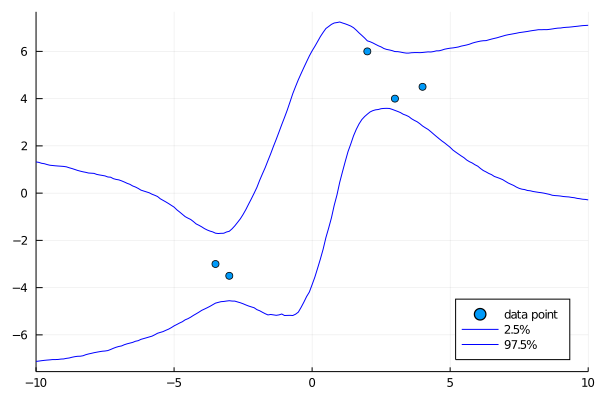

In [ ]:
p1=scatter(x,t, xlims=(-10,10), label="data point", legend=:bottomright)
plot!(x_range,interval[1,:], label="2.5%", color="blue")
plot!(x_range,interval[2,:], label="97.5%", color="blue")
# The space between two lines is the 95% C.I.

## B) Add measurement error to x variable so that x~N(0,0.5)

In [ ]:
errors = rand(Normal(0,0.5),5)

5-element Array{Float64,1}:
 -0.9870010355846613
 -0.3293117238933405
  0.05264540827058056
  0.29818345852854566
  0.15273470805952558

In [ ]:
x_err = x .+ errors

5-element Array{Float64,1}:
 -3.9870010355846612
  1.6706882761066595
  3.0526454082705805
 -3.2018165414714543
  4.152734708059525

In [ ]:
fns_xerr = Matrix{Real}(undef,5001,length(x_range))

W = rand(Normal(), (3 * N + 1))
accepts = 0

# Replace the input data
M = loss(W,x_err,t,alpha)
dW = gradient(() -> loss(W,x_err,t,alpha), Flux.params(W))[W]

for k in 1:5001
    dH, new_W, new_dW, new_M = step(W,dW,M)
    
    if (dH < 0) || (rand(Uniform(),1)[1] < exp(-dH))
        accepts += 1
        W = new_W
        M = new_M
        dW = new_dW
        
        # For computing the C.I., collect the accepted y
        y_range = map(i -> forward_step(W,i)[1], x_range)
        y_range = reshape(y_range,1,201)
        for idx in 1:length(x_range)
            fns_xerr[accepts,:] = y_range
        end
    end
end

In [ ]:
# Computing C.I.
for row in 5001: -1: (accepts+1)
    fns_xerr[row,:]=ones(1,length(x_range))
end
for row in 5001: -1: (accepts+1)
    fns_xerr = fns_xerr[setdiff(1:end, row), :] # Delete all undef rows
end

interval_xerr = Matrix{Real}(undef,2,length(x_range))
for each_x in 1:length(x_range)
    fns_xerr[:,each_x] = sort(fns_xerr[:,each_x])
    interval_xerr[:,each_x] = quantile(fns_xerr[:,each_x], [0.025,0.975])
end

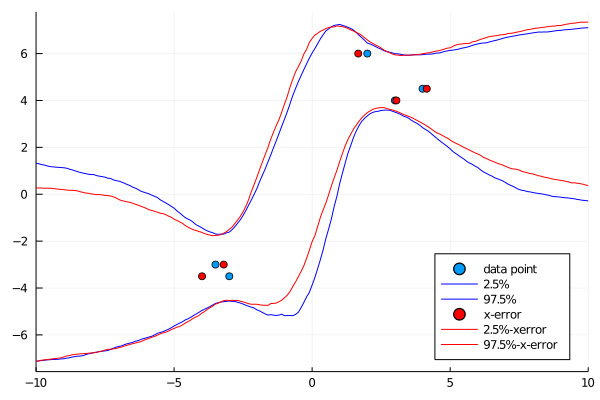

In [ ]:
p1
scatter!(x_err,t, label="x-error", color="red")
plot!(x_range,interval_xerr[1,:], label="2.5%-xerror", color="red")
plot!(x_range,interval_xerr[2,:], label="97.5%-x-error", color="red")

The C.I. becomes a little bit more narrow than before.

## C) Add measurement error to y variable so that y~N(0,0.5)

In [ ]:
t_err = t .+ errors

5-element Array{Float64,1}:
 -4.487001035584662
  5.6706882761066595
  4.052645408270581
 -2.7018165414714543
  4.652734708059525

In [ ]:
fns_terr = Matrix{Real}(undef,5001,length(x_range))

W = rand(Normal(), (3 * N + 1))
accepts = 0

# Replace the input data
M = loss(W,x,t_err,alpha)
dW = gradient(() -> loss(W,x,t_err,alpha), Flux.params(W))[W]

for k in 1:5001
    dH, new_W, new_dW, new_M = step(W,dW,M)
    
    if (dH < 0) || (rand(Uniform(),1)[1] < exp(-dH))
        accepts += 1
        W = new_W
        M = new_M
        dW = new_dW
        
        # For computing the C.I., collect the accepted y
        y_range = map(i -> forward_step(W,i)[1], x_range)
        y_range = reshape(y_range,1,201)
        for idx in 1:length(x_range)
            fns_terr[accepts,:] = y_range
        end
    end
end
# Computing C.I.
for row in 5001: -1: (accepts+1)
    fns_terr[row,:]=ones(1,length(x_range))
end
for row in 5001: -1: (accepts+1)
    fns_terr = fns_terr[setdiff(1:end, row), :]
end

interval_terr = Matrix{Real}(undef,2,length(x_range))
for each_x in 1:length(x_range)
    fns_terr[:,each_x] = sort(fns_terr[:,each_x])
    interval_terr[:,each_x] = quantile(fns_terr[:,each_x], [0.025,0.975])
end

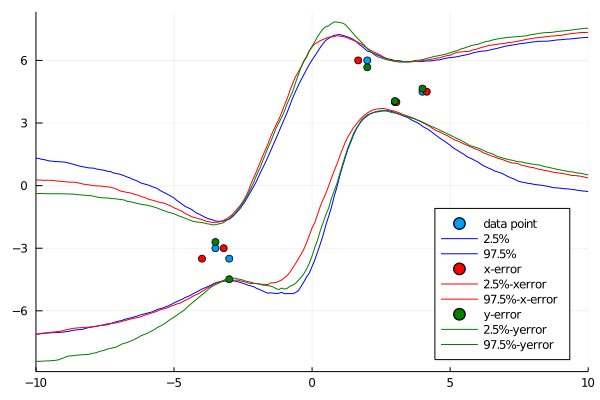

In [ ]:
p1
scatter!(x,t_err, label="y-error", color="green")
plot!(x_range,interval_terr[1,:], label="2.5%-yerror", color="green")
plot!(x_range,interval_terr[2,:], label="97.5%-yerror", color="green")

The tendency of C.I.s and the inference results are similar to each other.